In [86]:
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import shap

,INCOME,R_DEBT_INCOME,R_EXPENDITURE,R_EXPENDITURE_SQR,R_EXPENDITURE_SAVINGS,R_ENTERTAINMENT,GAMBLING_LOW,GAMBLING_HIGH
0,26615,35.7503,0.5797,0.336052,0.0000,0.5065,0,1
1,77158,1.0909,0.3580,0.128164,0.8333,0.5042,0,0
2,27825,26.1114,0.5698,0.324672,3.3334,0.6178,0,1
3,80657,8.8000,0.4985,0.248502,0.5263,0.5094,0,1
4,163604,3.0000,0.4604,0.211968,0.1020,0.5150,0,1


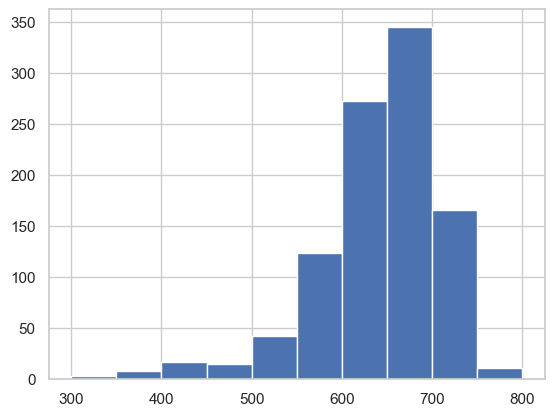

In [99]:
# fetch dataset 
credit_score = pd.read_csv("../../data/credit_score.csv")
credit_score['R_EXPENDITURE_SQR'] = credit_score['R_EXPENDITURE']**2

# data (as pandas dataframes) 
X = credit_score[['INCOME','R_DEBT_INCOME','R_EXPENDITURE','R_EXPENDITURE_SQR','R_EXPENDITURE_SAVINGS','R_ENTERTAINMENT','CAT_GAMBLING']].copy()

# one-hot encoding
X['GAMBLING_LOW'] = X['CAT_GAMBLING'].apply(lambda x: 1 if x == 'Low' else 0)
X['GAMBLING_HIGH']  = X['CAT_GAMBLING'].apply(lambda x: 1 if x == 'High' else 0)
X.drop(columns=['CAT_GAMBLING'], inplace=True)

y = credit_score['CREDIT_SCORE']

y.hist()
X.head()


In [101]:
# Add a constant to the independent variables (intercept)
X = sm.add_constant(X)

# Fit a linear regression model
model = sm.OLS(y, X).fit()

# Output the summary of the model
model_summary = model.summary()

# Print the summary
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     863.2
Date:                Tue, 24 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:40:59   Log-Likelihood:                -4617.3
No. Observations:                1000   AIC:                             9253.
Df Residuals:                     991   BIC:                             9297.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   631.78

# Plot of residuals

Text(0, 0.5, 'Actual')

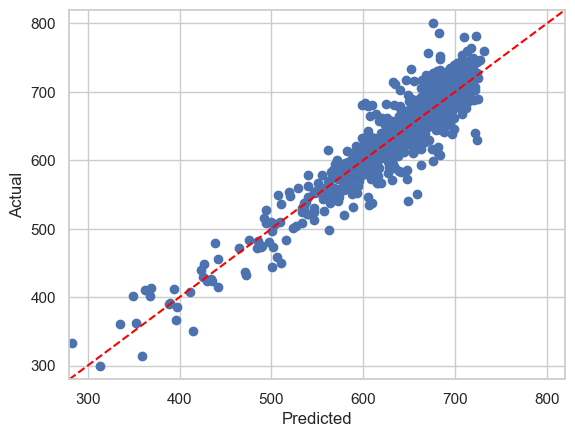

In [90]:
#plot predicted vs actual and straight line
y_pred = model.predict(X)
plt.scatter(y_pred,y)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red', linestyle='--')
plt.ylim(280,820)
plt.xlim(280,820)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Feature importance (absolute t-statistic)

Text(0.5, 1.0, 'Feature Importance')

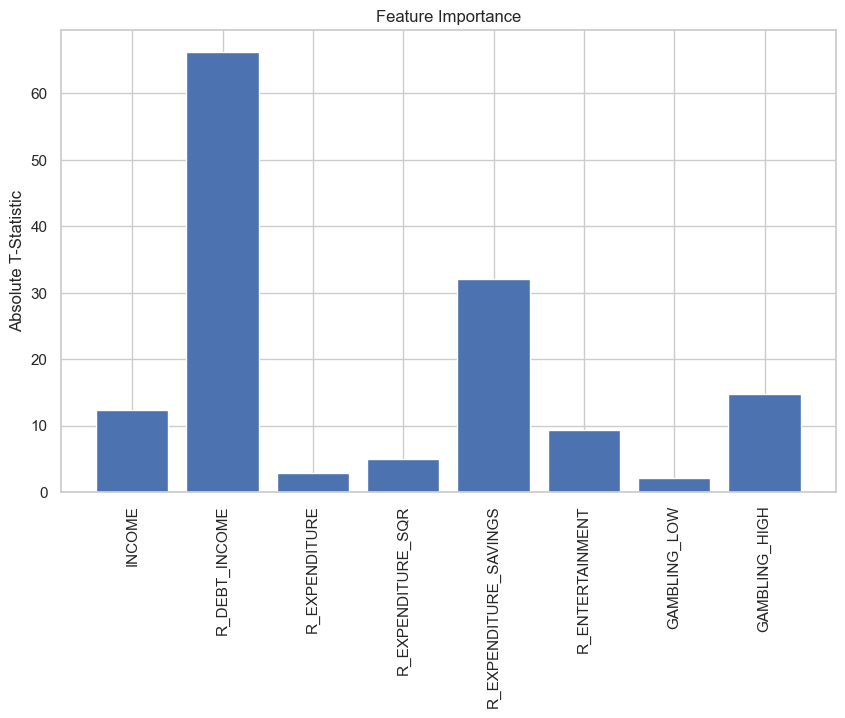

In [91]:
# Get the absolute values of the t-statistics from the model
abs_t_statistic = abs(model.tvalues)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.bar(X.columns[1:], abs_t_statistic[1:])  # Exclude the 'quality' column
plt.ylabel('Absolute T-Statistic')
plt.xticks(rotation=90)
plt.title('Feature Importance')

# T-statistic

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'INCOME'),
  Text(1, 0, 'R_DEBT_INCOME'),
  Text(2, 0, 'R_EXPENDITURE'),
  Text(3, 0, 'R_EXPENDITURE_SQR'),
  Text(4, 0, 'R_EXPENDITURE_SAVINGS'),
  Text(5, 0, 'R_ENTERTAINMENT'),
  Text(6, 0, 'GAMBLING_LOW'),
  Text(7, 0, 'GAMBLING_HIGH')])

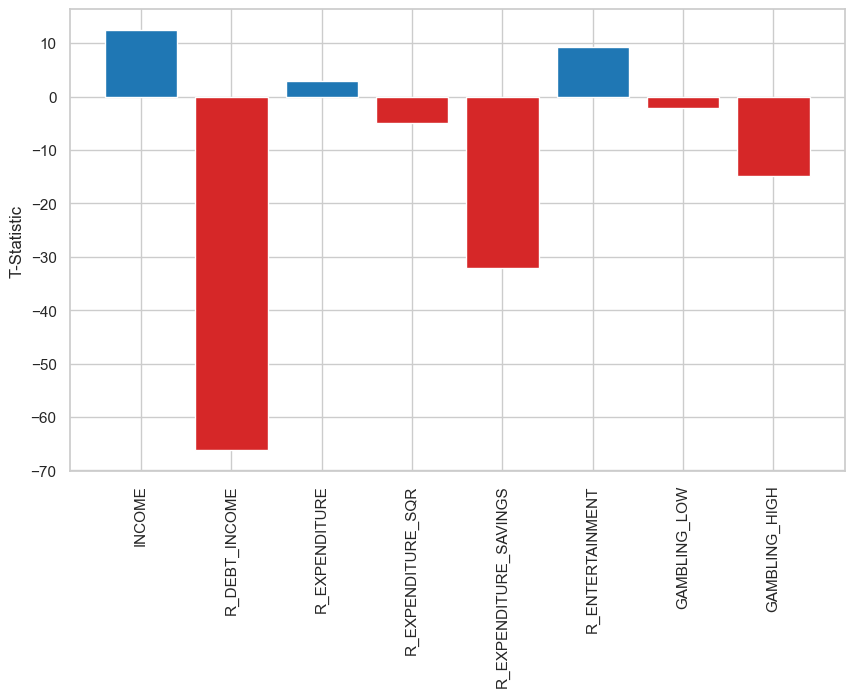

In [92]:
# Create a bar plot for feature importance with conditional coloring
plt.figure(figsize=(10, 6))
t_statistic = model.tvalues[1:]  # Exclude the constant
colors = ['tab:red' if t < 0 else 'tab:blue' for t in t_statistic]

plt.bar(X.columns[1:], t_statistic, color=colors)
plt.ylabel('T-Statistic')
plt.xticks(rotation=90)

## Weight plot

Text(0.5, 0, 'Coefficient (Weight)')

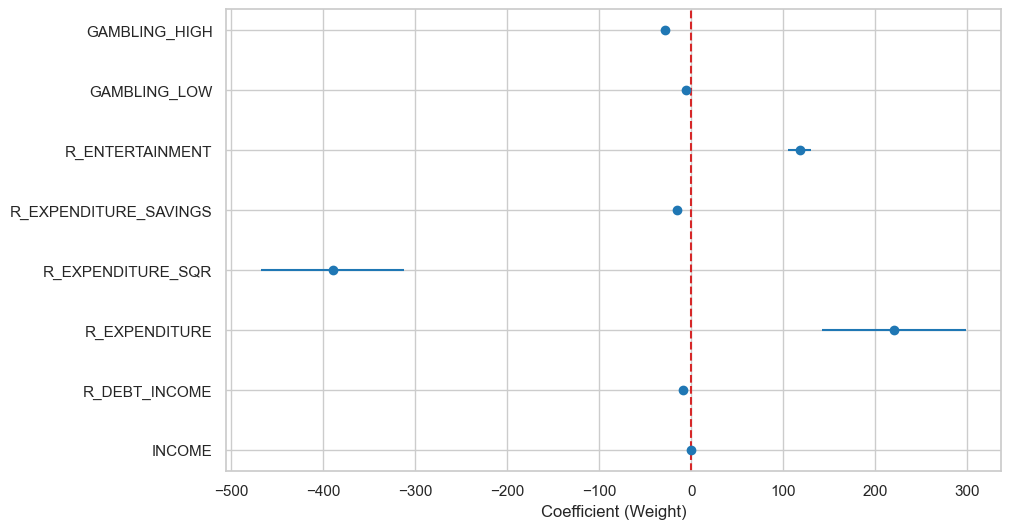

In [93]:
# Get the coefficient values for each feature (excluding the intercept)
coefficients = model.params[1:]
# Get the standard errors for each coefficient
se = model.bse[1:]

# Create a weight plot with features on the y-axis
plt.figure(figsize=(10, 6))

# Plot vertical dotted line at x=0
plt.axvline(x=0, color='tab:red', linestyle='--')

# Plot the coefficients as dots with error bars
plt.errorbar(coefficients, X.columns[1:], xerr=se, fmt='o', color='tab:blue', ecolor='tab:blue')

# Set labels and title
plt.xlabel('Coefficient (Weight)')

In [95]:
# Scale the features to be between 0 and 1 using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.drop(columns='const'))
X_scaled = pd.DataFrame(X_scaled, columns=X.columns[1:])

X_scaled = sm.add_constant(X_scaled)
# Fit a linear regression model with scaled features
model_scaled = sm.OLS(y, X_scaled).fit()

print(model_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     863.2
Date:                Fri, 20 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:17:54   Log-Likelihood:                -4617.3
No. Observations:                1000   AIC:                             9253.
Df Residuals:                     991   BIC:                             9297.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   708.34

Text(0.5, 0, 'Coefficient (Weight)')

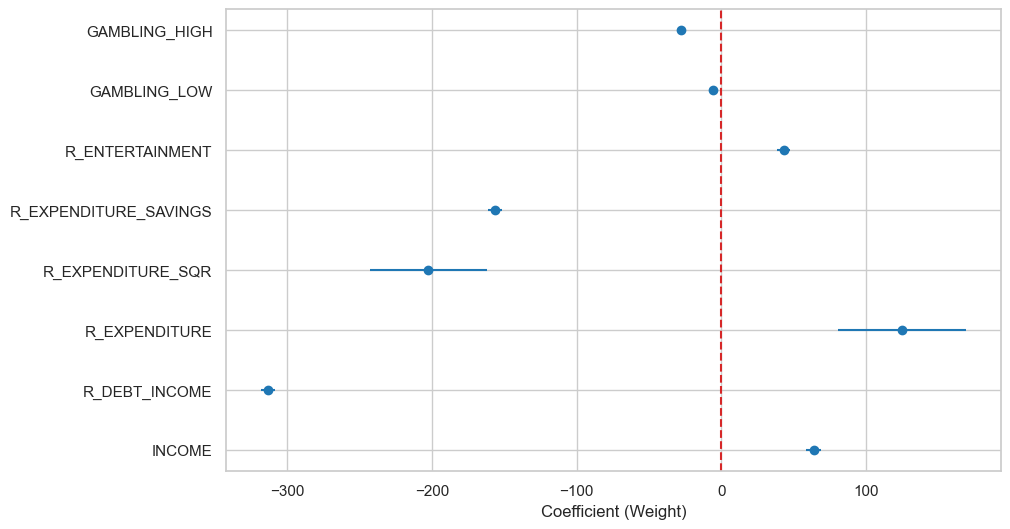

In [96]:
# Get the coefficient values for each feature (excluding the intercept)
coefficients = model_scaled.params[1:]
# Get the standard errors for each coefficient
se = model_scaled.bse[1:]

# Create a weight plot with features on the y-axis
plt.figure(figsize=(10, 6))

# Plot vertical dotted line at x=0
plt.axvline(x=0, color='tab:red', linestyle='--')

# Plot the coefficients as dots with error bars
plt.errorbar(coefficients, X_scaled.columns[1:], xerr=se, fmt='o', color='tab:blue', ecolor='tab:blue')

# Set labels and title
plt.xlabel('Coefficient (Weight)')

## Effect plot

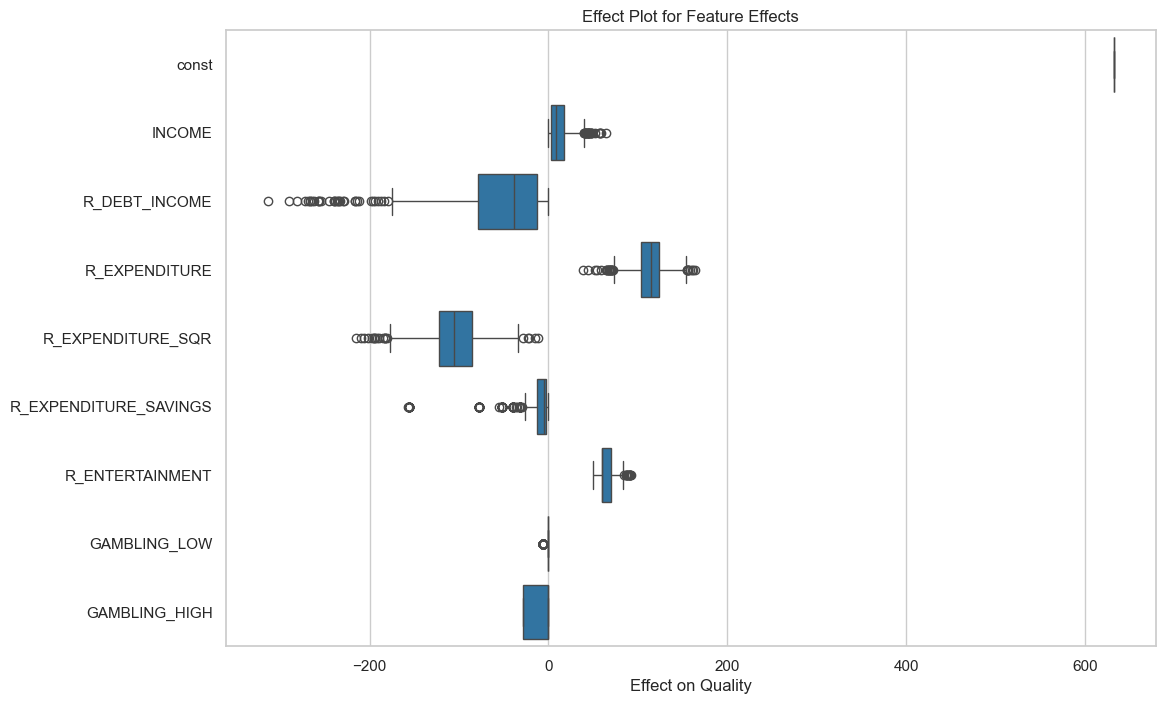

In [97]:
# Calculate the feature effects by multiplying weights with feature values
feature_effects = X * model.params

# Create effect plots using boxplots
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue")
plt.title("Effect Plot for Feature Effects")
plt.xlabel("Effect on Quality")
plt.show()

## Individual effect plot

In [28]:
X[1:]

,const,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
1,1.0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5
2,1.0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1
3,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9
4,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9
5,1.0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,1.0,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
4894,1.0,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
4895,1.0,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
4896,1.0,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


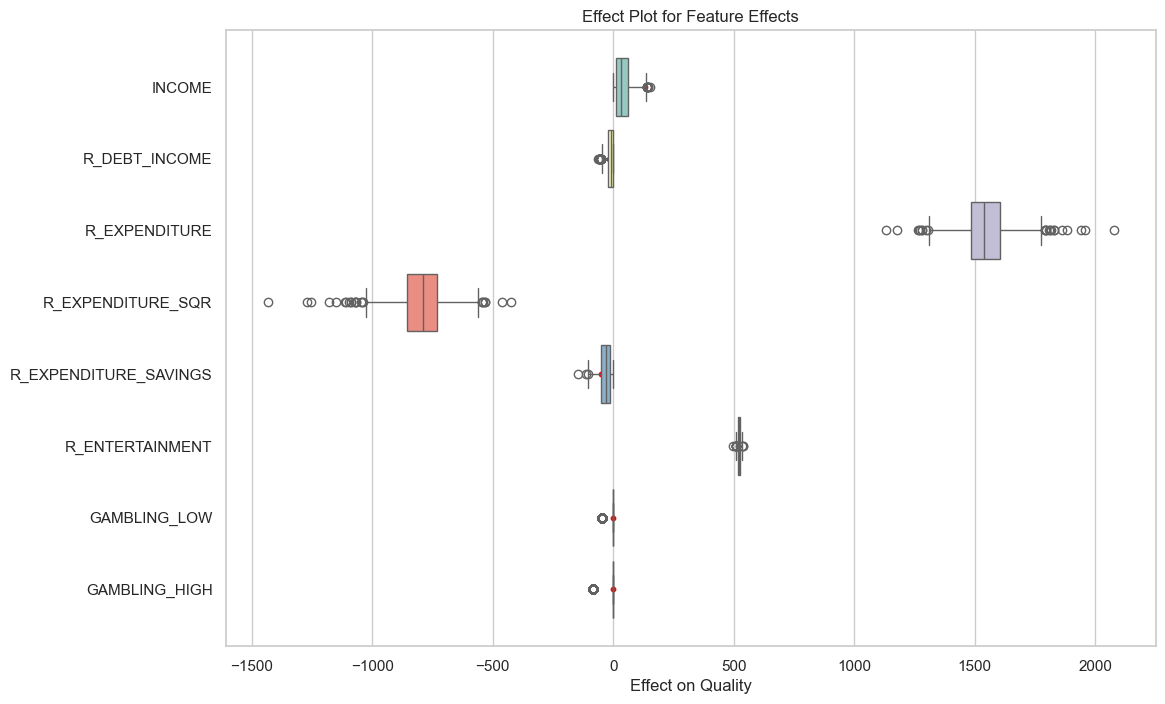

In [55]:
X.drop('const', axis=1, inplace=True)

# Calculate the feature effects by multiplying weights with feature values
feature_effects = X * model.params[1:]

idx = 0  # You can change this to any valid index in your dataset
ind_feature_effect = X.iloc[idx] * model.params[1:]

# Create effect plots using boxplots
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.boxplot(data=feature_effects, orient="h", palette="Set3")

for i, feature in enumerate(X):
    plt.scatter(ind_feature_effect [i], i, c='red', marker='o', s=10)

plt.title("Effect Plot for Feature Effects")
plt.xlabel("Effect on Quality")
plt.show()

# Mean adjusted individual effect plot
<br>
good for contrastive explanations

# Scatter plots of features

# PDPs

## SHAP values

In [57]:
X

,INCOME,R_DEBT_INCOME,R_EXPENDITURE,R_EXPENDITURE_SQR,R_EXPENDITURE_SAVINGS,R_ENTERTAINMENT,GAMBLING_LOW,GAMBLING_HIGH
0,317138,9.0000,0.5256,0.276255,0.5000,0.5038,0,0
1,270712,12.0000,0.5396,0.291168,0.3333,0.5061,0,0
2,43138,6.0000,0.4978,0.247805,1.0000,0.5102,0,0
3,0,8.4538,0.3775,0.142506,0.3333,0.5106,1,0
4,259917,15.0000,0.5362,0.287510,0.3333,0.5025,0,0
...,...,...,...,...,...,...,...,...
995,98150,8.0000,0.5392,0.290737,0.5000,0.5175,0,0
996,72332,3.0000,0.5287,0.279524,1.0000,0.5084,0,0
997,0,3.9641,0.4495,0.202050,0.5000,0.5006,1,0
998,118955,3.0000,0.5304,0.281324,0.0000,0.5087,0,1


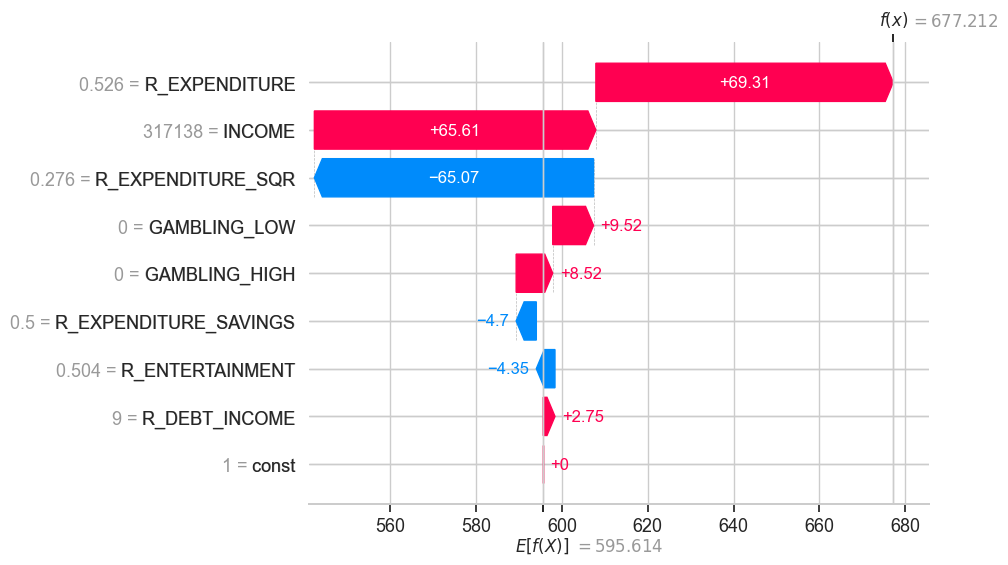

In [60]:
# Calculate SHAP values
explainer = shap.Explainer(model.predict,X[0:10])
shap_values = explainer(X)

shap.plots.waterfall(shap_values[0])

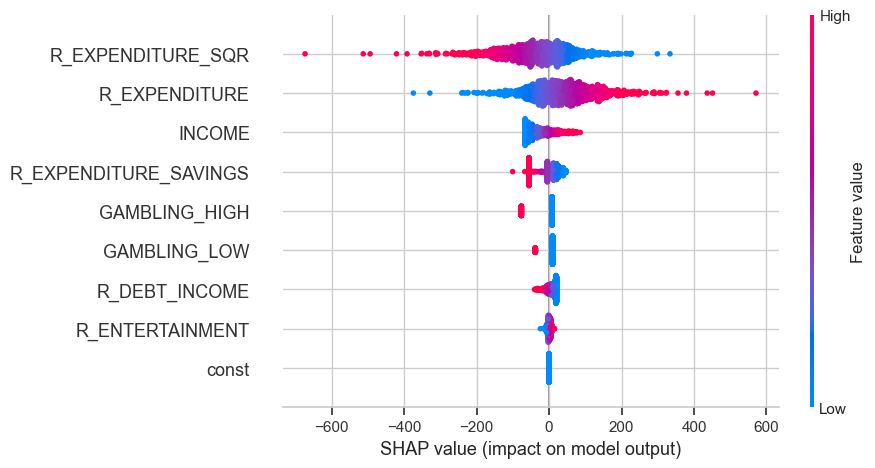

In [61]:
#SHAP beeswarm plot
shap.plots.beeswarm(shap_values)

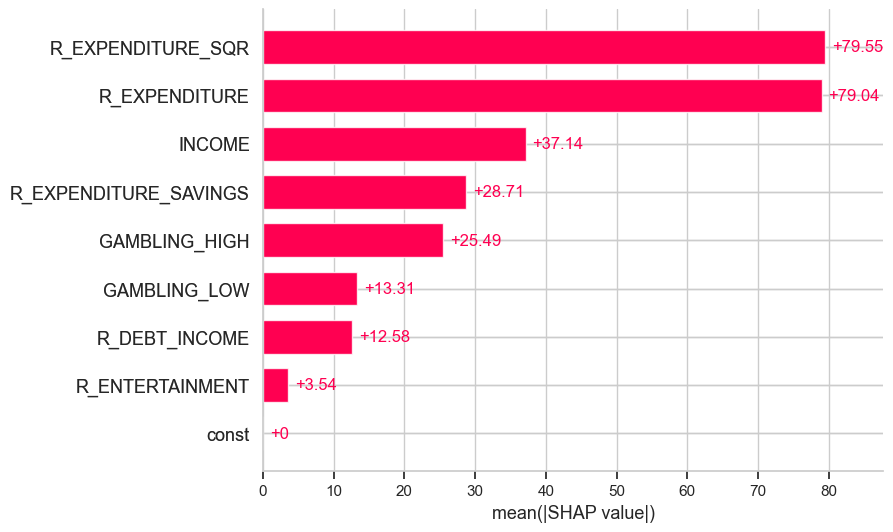

In [62]:
# SHAP bar plot
shap.plots.bar(shap_values)

## PDPs

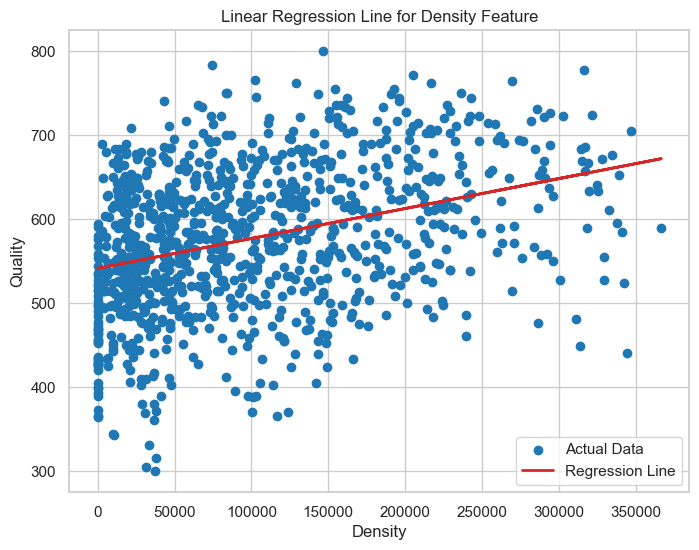

In [65]:
from sklearn.linear_model import LinearRegression

# Create and train a linear regression model
model = LinearRegression()
model.fit(X[['INCOME']], y)

# Extract the intercept and coefficient from the model
intercept = model.intercept_
coefficient = model.coef_[0]

# Generate data points for the line
density_values = X[['INCOME']]
predicted_values = intercept + coefficient * density_values

# Create a line chart for the density feature
plt.figure(figsize=(8, 6))
plt.scatter(X['INCOME'], y, color='tab:blue', label='Actual Data')
plt.plot(density_values, predicted_values, color='tab:red', linewidth=2, label='Regression Line')
plt.xlabel('Density')
plt.ylabel('Quality')
plt.title('Linear Regression Line for Density Feature')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
from sklearn.linear_model import LinearRegression

# Create and train a linear regression model
model = LinearRegression()
model.fit(X, y)

# Output the parameter values (coefficients)
parameter_values = model.coef_

print("Parameter Values (Coefficients):")
for feature, coef in zip(X.columns, parameter_values):
    print(f"{feature}: {coef}")


Parameter Values (Coefficients):
const: 0.0
INCOME: 0.00041512681478850515
R_DEBT_INCOME: -2.045362297858912
R_EXPENDITURE: 2996.728033793327
R_EXPENDITURE_SQR: -2981.643435890794
R_EXPENDITURE_SAVINGS: -101.41139157470504
R_ENTERTAINMENT: 1028.1701265034508
GAMBLING_LOW: -47.57800443476181
GAMBLING_HIGH: -85.19042648717685


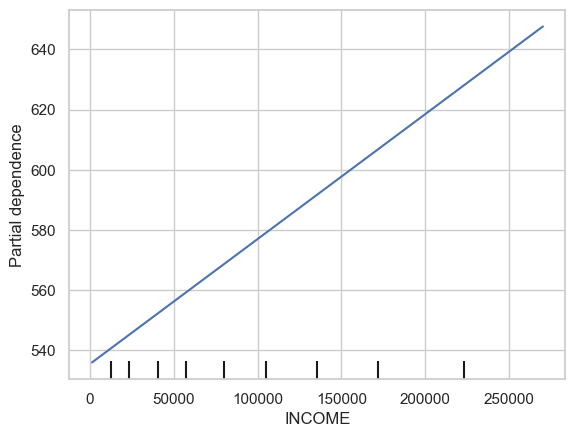

In [67]:
from sklearn.inspection import PartialDependenceDisplay as PDP

PDP.from_estimator(model, X, ['INCOME'])